# EDA (Exploratory Data Analysis)

Before diving into model training, let's conduct a comprehensive analysis of the data.

In [97]:
! pip install jiwer

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [122]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_metric
import re
import math

In [98]:
# For calculating WER (Word Error Rate)

train_df = pd.read_csv("/kaggle/input/dataverse_2023/trainIPAdb_u.csv")
test_df = pd.read_csv("/kaggle/input/dataverse_2023/testData.csv", index_col="row_id_column_name")

print("Total number of training samples:", len(train_df))
print("Total number of test samples:", len(test_df))

Total number of training samples: 21999
Total number of test samples: 27228


In [99]:
train_df.head()

,text,ipa
0,এরপরও তারা বকেয়া পরিশোধ করেনি।,eɾpɔɾo t̪ɐɾɐ bɔkeʲɐ poɾɪʃod̪ʱ kɔɾenɪ।
1,আগে সুইস ব্যাংকে জমা টাকার কোনো প্রতিবেদন প্রক...,ɐge suɪ̯s bɛŋke ɟɔmɐ tɐkɐɾ kono pɾot̪ɪbed̪ɔn p...
2,আদালত প্রতিষ্ঠানটি সিলগালা করে দেয়।,ɐd̪ɐlɔt̪ pɾot̪ɪʃtʱɐntɪ sɪlgɐlɐ koɾe d̪ee̯।
3,রায়ে তাদের দোষী সাব্যস্ত করা হলেও সাজা আগামী স...,ɾɐe t̪ɐd̪eɾ d̪oʃɪ ʃɐbbost̪o kɔɾɐ holeo̯ ʃɐɟɐ ɐ...
4,গ্রেফতারের পর থেকে তাদের বাঁচাতে এলাকার প্রভাব...,gɾepʰt̪ɐɾeɾ pɔɾ t̪ʰeke t̪ɐd̪eɾ bɐ̃cɐt̪e elɐkɐɾ...


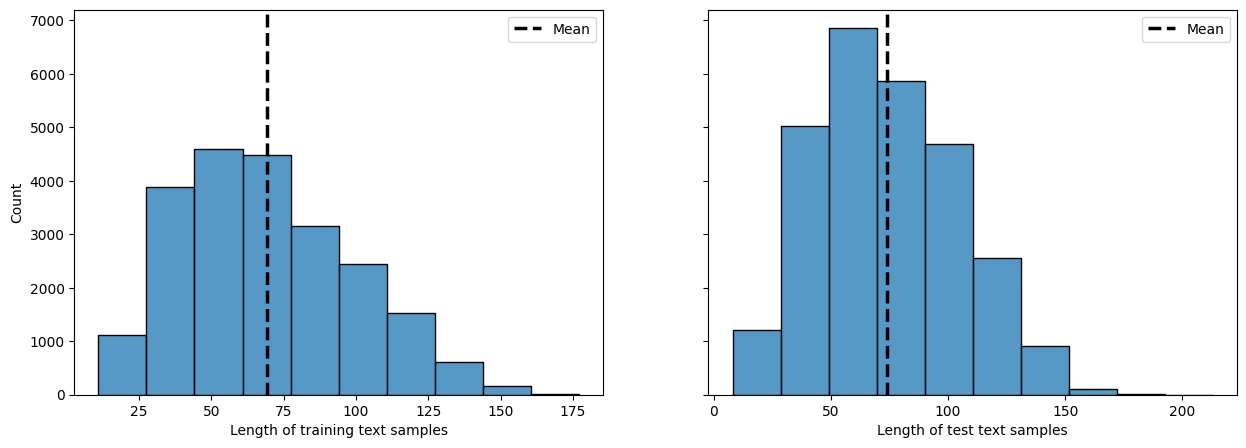

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

train_lengths = train_df["text"].str.len()
sns.histplot(ax=axes[0], data=train_lengths, bins=10).set(xlabel="Length of training text samples")
axes[0].axvline(train_lengths.mean(), c="k", ls="--", lw=2.5, label="Mean")
axes[0].legend()

test_lengths = test_df["text"].str.len()
sns.histplot(ax=axes[1], data=test_lengths, bins=10).set(xlabel="Length of test text samples")
axes[1].axvline(test_lengths.mean(), c="k", ls="--", lw=2.5, label="Mean")
axes[1].legend()


plt.show()

Now, let's find out the number of unique words in both training and test data.

In [120]:
train_corpus = train_df["text"].sum()
test_corpus = test_df["text"].sum()

# Remove punctuations
chars_to_ignore = '[-,\.:;\'"!\?।]'

train_corpus = re.sub(chars_to_ignore, ' ', train_corpus)
train_vocab = set(train_corpus.split())

test_corpus = re.sub(chars_to_ignore, ' ', test_corpus)
test_vocab = set(test_corpus.split())

oov = test_vocab - train_vocab

print("Number of unique words in training data:", len(train_vocab))
print("Number of unique words in test data:", len(test_vocab))
print("Number of out-of-vocabulary (OOV) words:", len(oov))

Number of unique words in training data: 30715
Number of unique words in test data: 40165
Number of out-of-vocabulary (OOV) words: 22880


In [121]:
# Filtering text samples that contain English alphanumeric values
filtered_train = train_df[lambda x: x["text"].str.contains("[A-Za-z0-9]")]

with pd.option_context('display.max_colwidth', 0):
    display(filtered_train.tail(n=10))

,text,ipa


In [123]:
bangla_numerals = "[০১২৩৪৫৬৭৮৯]"

filtered_train = train_df[lambda x: x["text"].str.contains(bangla_numerals)]
filtered_test = test_df[lambda x: x["text"].str.contains(bangla_numerals)]

print("Number of training samples containing Bangla numerals:", len(filtered_train))
print("Number of test samples containing Bangla numerals:", len(filtered_test))

Number of training samples containing Bangla numerals: 0
Number of test samples containing Bangla numerals: 0


# Training

In [104]:
# Remove English alphanumeric values
alpha_pat = "[a-zA-z0-9]"

train_df["text"] = train_df["text"].str.replace(alpha_pat, "", regex=True)
test_df["text"] = test_df["text"].str.replace(alpha_pat, "", regex=True)

# Preprocessing Bangla Numeric Numbers: Converting Bangla Numbers to Texts

**How the numbers should be handled depends on the Context.**

Case 1 :  "I will get 10 dollar from him."   It should be treated as 
          "I will get ten dollar from him."

Case 2 :  "His mobile number is 0171243212". It should be treated as
          "His mobile number is Zero One Seven One......"

In [113]:
numeric_words = {
    '.': 'দশমিক',
    '0': 'শুন্য',
    '1': 'এক',
    '2': 'দুই',
    '3': 'তিন',
    '4': 'চার',
    '5': 'পাঁচ',
    '6': 'ছয়',
    '7': 'সাত',
    '8': 'আট',
    '9': 'নয়',
    '10': 'দশ',
    '11': 'এগারো',
    '12': 'বার',
    '13': 'তের',
    '14': 'চৌদ্দ',
    '15': 'পনের',
    '16': 'ষোল',
    '17': 'সতের',
    '18': 'আঠার',
    '19': 'উনিশ',
    '20': 'বিশ',
    '21': 'একুশ',
    '22': 'বাইশ',
    '23': 'তেইশ',
    '24': 'চব্বিশ',
    '25': 'পঁচিশ',
    '26': 'ছাব্বিশ',
    '27': 'সাতাশ',
    '28': 'আঠাশ',
    '29': 'ঊনত্রিশ',
    '30': 'ত্রিশ',
    '31': 'একত্রিশ',
    '32': 'বত্রিশ',
    '33': 'তেত্রিশ',
    '34': 'চৌত্রিশ',
    '35': 'পঁয়ত্রিশ',
    '36': 'ছত্রিশ',
    '37': 'সাঁইত্রিশ',
    '38': 'আটত্রিশ',
    '39': 'ঊনচল্লিশ',
    '40': 'চল্লিশ',
    '41': 'একচল্লিশ',
    '42': 'বিয়াল্লিশ',
    '43': 'তেতাল্লিশ',
    '44': 'চুয়াল্লিশ',
    '45': 'পঁয়তাল্লিশ',
    '46': 'ছেচল্লিশ',
    '47': 'সাতচল্লিশ',
    '48': 'আটচল্লিশ',
    '49': 'ঊনপঞ্চাশ',
    '50': 'পঞ্চাশ',
    '51': 'একান্ন',
    '52': 'বায়ান্ন',
    '53': 'তিপ্পান্ন',
    '54': 'চুয়ান্ন',
    '55': 'পঞ্চান্ন',
    '56': 'ছাপ্পান্ন',
    '57': 'সাতান্ন',
    '58': 'আটান্ন',
    '59': 'ঊনষাট',
    '60': 'ষাট',
    '61': 'একষট্টি',
    '62': 'বাষট্টি',
    '63': 'তেষট্টি',
    '64': 'চৌষট্টি',
    '65': 'পঁয়ষট্টি',
    '66': 'ছেষট্টি',
    '67': 'সাতষট্টি',
    '68': 'আটষট্টি',
    '69': 'ঊনসত্তর',
    '70': 'সত্তর',
    '71': 'একাত্তর',
    '72': 'বাহাত্তর',
    '73': 'তিয়াত্তর',
    '74': 'চুয়াত্তর',
    '75': 'পঁচাত্তর',
    '76': 'ছিয়াত্তর',
    '77': 'সাতাত্তর',
    '78': 'আটাত্তর',
    '79': 'ঊনআশি',
    '80': 'আশি',
    '81': 'একাশি',
    '82': 'বিরাশি',
    '83': 'তিরাশি',
    '84': 'চুরাশি',
    '85': 'পঁচাশি',
    '86': 'ছিয়াশি',
    '87': 'সাতাশি',
    '88': 'আটাশি',
    '89': 'ঊননব্বই',
    '90': 'নব্বই',
    '91': 'একানব্বই',
    '92': 'বিরানব্বই',
    '93': 'তিরানব্বই',
    '94': 'চুরানব্বই',
    '95': 'পঁচানব্বই',
    '96': 'ছিয়ানব্বই',
    '97': 'সাতানব্বই',
    '98': 'আটানব্বই',
    '99': 'নিরানব্বই',
    '100': 'একশো',
}

units = {
    'koti': 'কোটি',
    'lokkho': 'লক্ষ',
    'hazar': 'হাজার',
    'sotok': 'শো',
    'ekok': '',
}

def input_sanitizer(number):
    if isinstance(number, float) or isinstance(number, int) or \
            isinstance(number, str):
        if isinstance(number, str):
            try:
                if "." in number:
                    number = float(number)
                else:
                    number = int(number)
            except ValueError:
                return None
        return number
    else:
        return None


def generate_segments(number):
    """
    Generating the unit segments such as koti, lokkho
    """
    segments = dict()
    _number = number
    segments['koti'] = math.floor(_number/10000000)
    _number = _number % 10000000
    segments['lokkho'] = math.floor(_number/100000)
    _number = _number % 100000
    segments['hazar'] = math.floor(_number/1000)
    _number = _number % 1000
    segments['sotok'] = math.floor(_number/100)
    _number = _number % 100
    segments['ekok'] = _number

    if number == 0:
        segments['ekok'] = [0, True]

    return segments


def float_int_extraction(number):
    """
    Extracting the float and int part from the passed number. The first return
    is the part before the decimal point and the rest is the fraction.
    """
    _number = str(number)
    if "." in _number:
        return tuple([int(x) for x in _number.split(".")])
    else:
        return number, None


def whole_part_word_gen(segments):
    """
    Generating the bengali word for the whole part of the number
    """
    generated_words = ''
    for segment in segments:
        if segments[segment]:
            if isinstance(segments[segment], list):
                generated_words = generated_words + " " + numeric_words["0"]+" "+units[segment]
            else:
                generated_words = generated_words +" "+ numeric_words[str(segments[segment])]+" "+ units[segment]

    return generated_words


def fraction_to_words(fraction):
    """
    Generating bengali words for the part after the decimal point
    """
    generated_words = ""
    for digit in str(fraction):
        generated_words += numeric_words[digit] + " "
    return generated_words[:-1]

def to_bn_word(number):
    """
    Takes a number and outputs the word form in Bengali for that number.
    """

    generated_words = ""

    number = input_sanitizer(number)


    whole, fraction = float_int_extraction(number)

    whole_segments = generate_segments(whole)

    generated_words = whole_part_word_gen(whole_segments)

    if fraction:
        if generated_words:
            return generated_words + " দশমিক " + fraction_to_words(fraction)
        else:
            return "দশমিক " + fraction_to_words(fraction)
    else:
        return generated_words

In [124]:
def numeric_to_text(numeric):
    # transforms numeric values to text values

    # if the numeric has commas, we will ignore the comma unless it is the last digit
    has_comma_last = False
    if numeric[-1] == ",":
        has_comma_last = True
    numeric = numeric.replace(",", "")

    # Length of number is less than 10
    if len(numeric) < 10:

        if numeric[0] == "০":
            if "-" in numeric: #I changed here
              segments = numeric.split("-")
              text = [to_bn_word(segment) if segment != "" else segment for segment in segments]
              text = "-".join(text)
              text = text.replace("- ", "-")
              text = text.replace(" -", "-")
              if has_comma_last:
                 return text + ","
              else:
                 return text

            if "." in numeric: #I changed here
              segments = numeric.split(".")
              text = [to_bn_word(segment) if segment != "" else segment for segment in segments]
              text = " দশমিক ".join(text)
              if has_comma_last:
                  return text + ","
              else:
                  return text

            if "/" in numeric: #I changed here
              segments = numeric.split("/")
              text = [to_bn_word(segment) if segment != "" else segment for segment in segments]
              text = "/".join(text)
              text = text.replace("/ ", "/")
              text = text.replace(" /", "/")
              if has_comma_last:
                 return text + ","
              else:
                 return text

            text = [to_bn_word(digit) for digit in numeric]
            text = " ".join(text)
            if has_comma_last:
                return text + ","
            else:
                return text

        # If the numeric contains -
        elif "-" in numeric:
            segments = numeric.split("-")
            text = [to_bn_word(segment) if segment != "" else segment for segment in segments]
            text = "-".join(text)
            text = text.replace("- ", "-")
            text = text.replace(" -", "-")

            if has_comma_last:
                return text + ","
            else:
                return text

        # If the numeric contains /
        elif "/" in numeric:
            segments = numeric.split("/")
            text = [to_bn_word(segment) if segment != "" else segment for segment in segments]
            text = "/".join(text)
            text = text.replace("/ ", "/")
            text = text.replace(" /", "/")
            if text[-1] == ' ':
                text = text[:-1]
            if text[0] == ' ':
                text = text[1:] 
            if has_comma_last:
                return text + ","
            else:
                return text

        # If the numeric contains .
        elif "." in numeric:
            segments = numeric.split(".")

            #whole = [to_bn_word(segments[0])]
            whole = [to_bn_word(segments[0])] if segments[0] else [""] # I changed here
            text = [(" ").join([to_bn_word(digit) for digit in segment]) if segment != "" else segment for segment in segments[1:]]
            text = whole + text
            text = " দশমিক ".join(text)
            if has_comma_last:
                return text + ","
            else:
                return text

        else:
            text = to_bn_word(numeric)
            if text[-1] == ' ':
                text = text[:-1]
            if text[0] == ' ':
                text = text[1:] 
            if has_comma_last:
                return text + ","
            else:
                return text

    else:
        # Length of number is greater than 9
        # numbers may have - inbetween the digits
        if "-" in numeric:
            segments = numeric.split("-")
            num_lens = [len(segment) for segment in segments]
            if max(num_lens) > 4:
                text = [(" ").join([to_bn_word(digit) for digit in segment]) if segment != "" else segment for segment in segments]
                text = "-".join(text)
                text = text.replace("- ", "-")
                text = text.replace(" -", "-")

                if has_comma_last:
                    return text + ","
                else:
                    return text
            else:
                text = [to_bn_word(segment) if segment != "" else segment for segment in segments]
                text = "-".join(text)
                if has_comma_last:
                    return text + ","
                else:
                    return text

        # numbers may have / inbetween the digits
        elif "/" in numeric:
            segments = numeric.split("/")
            text = [(" ").join([to_bn_word(digit) for digit in segment]) if segment != "" else segment for segment in segments]
            text = "/".join(text)
            if has_comma_last:
                return text + ","
            else:
                return text

        # numbers may have / inbetween the digits
        elif "." in numeric:
            segments = numeric.split(".")
            whole = [to_bn_word(segments[0])]
            text = [(" ").join([to_bn_word(digit) for digit in segment]) if segment != "" else segment for segment in segments[1:]]
            text = whole + text
            text = " দশমিক ".join(text)
            if has_comma_last:
                return text + ","
            else:
                return text

        else:
            text = [to_bn_word(digit) for digit in numeric]
            text = " ".join(text)
            if has_comma_last:
                return text + ","
            else:
                return text

def process_numeric_text(text):
    bangla_numbers = re.findall("[.]*[০১২৩৪৫৬৭৮৯]+[-/.,[০১২৩৪৫৬৭৮৯]*]*", text)
    num_to_text = [numeric_to_text(number) for number in bangla_numbers]

    for idx, number in enumerate(bangla_numbers):
        text = text.replace(number, num_to_text[idx], 1)

    return text

In [125]:
#Example
text = 'আগ্রহী সাবেক ছাত্রদের ০১৭২৭-৪৫০৪৬৪, ০১৭১১-২৬০৩২৬, ০১৭১১-৩৭১২৯৬, ০১৭১৫-০৬৩১১১, ০১৭১৫-৫০৬০৩০ নম্বরে যোগাযোগ করতে অনুরোধ করা হয়েছে।'
text_with_num = process_numeric_text(text)
print(text_with_num)

আগ্রহী সাবেক ছাত্রদের  শুন্য   এক   সাত   দুই   সাত-চার   পাঁচ   শুন্য   চার   ছয়   চার ,  শুন্য   এক   সাত   এক   এক-দুই   ছয়   শুন্য   তিন   দুই   ছয় ,  শুন্য   এক   সাত   এক   এক-তিন   সাত   এক   দুই   নয়   ছয় ,  শুন্য   এক   সাত   এক   পাঁচ-শুন্য   ছয়   তিন   এক   এক   এক ,  শুন্য   এক   সাত   এক   পাঁচ-পাঁচ   শুন্য   ছয়   শুন্য   তিন   শুন্য  নম্বরে যোগাযোগ করতে অনুরোধ করা হয়েছে।


In [116]:
for i in range(len(train_df)):
    train_df['text'].iloc[i] = process_numeric_text(train_df['text'].iloc[i])

for i in range(len(test_df)):
    test_df['text'].iloc[i] = process_numeric_text(test_df['text'].iloc[i])

# Handling Superscript

In [105]:
"""When dealing with IPA symbols that include superscript characters, such as õʷ or oʷ, 
   which are not representable in ASCII, we employ a substitution method. This involves
   replacing the superscript character with a unique marker to maintain compatibility
   within ASCII.

Here's how the replacement process works:
- Each superscript character is replaced with a dollar sign ($) both before and after the character.
- For example, õʷ becomes õ$w$ and oʷ becomes o$w$.

This substitution allows us to preserve the original IPA symbols while ensuring 
compatibility with ASCII representations.
"""

superscript_replacement = {                       
    "õʷ": "õ$w$",
    "oʷ": "o$w$",
    "o̯ʲ": "o̯$j$",
    "oʲ": "o$j$",
    "o̯ʷ": "o̯$w$",
    "oʱ": "o$ɦ$",
    "nʲ": "n$j$",
    "ŋʲ": "ŋ$j$",
    "sʲ": "s$j$",
    "ɪʲʷ": "ɪ$jw$",
    "pʰ": "p$h$",
    "e̯ʲ": "e̯$j$",
    "ɐ̯ʲ": "ɐ̯$j$",
    "ɛʲ": "ɛ$j$",
    "ɐ̯ʷ": "ɐ̯$w$",
    "d̪ʱ": "d̪$ɦ$",
    "tʰ": "t$h$",
    "ɪʲ": "ɪ$j$",
    "ʃʲ": "ʃ$j$",
    "ɐʲ": "ɐ$j$",
    "lʲ": "l$j$",
    "ɪʷ": "ɪ$w$",
    "ɐʷ": "ɐ$w$",
    "eʲ": "e$j$",
    "ɪ̯ʲ": "ɪ̯$j$",
    "uʲ": "u$j$",
    "ɾʷ": "ɾ$w$",
    "uʷ": "u$w$",
    "ũʲ": "ũ$j$",
    "t̪ʰ": "t̪$h$",
    "bʱ": "b$ɦ$",
    "cʰ": "c$h$",
    "ɐ̯̃ʲ": "ɐ̯̃$j$",
    "ɔʲ": "ɔ$j$",
    "ɽʱ": "ɽ$ɦ$",
    "dʱ": "d$ɦ$",
    "ɐ̃ʲ": "ɐ̃$j$",
    "tʱ": "t$ɦ$",
    "ẽʲ": "ẽ$j$",
    "kʰ": "k$h$",
    "u̯ʲ": "u̯$j$",
    "ɔʷ": "ɔ$w$",
    "ɟʱ": "ɟ$ɦ$",
    "gʱ": "g$ɦ$",
    "u̯ʷ": "u̯$w$",
    "nʱ": "n$ɦ$"   
}
"""The 'unique_superscript_dict' is a dictionary used to map modified IPA superscript
   characters back to their original IPA representations.
"""

unique_superscript_dict = {
      'ʷ': '$w$',
      'ʲ': '$j$',
      'ʱ': '$ɦ$',
      'ʲʷ': '$jw$',
      'ʰ': '$h$'
     }

reverse_superscript_dict = {}
for key,value in unique_superscript_dict.items():
    reverse_superscript_dict[value] = key

In [106]:
for i in range(len(train_df)):
  text = train_df['ipa'].iloc[i]
  for key, value in superscript_replacement.items():
    text = text.replace(key, value)
  train_df['ipa'].iloc[i] = text
train_df['ipa'].iloc[0]

'eɾpɔɾo t̪ɐɾɐ bɔke$j$ɐ poɾɪʃod̪$ɦ$ kɔɾenɪ।'

In [107]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset

train_df, val_df = train_test_split(train_df, test_size=0.1, shuffle=True, random_state=3000)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

ds_train = Dataset.from_pandas(train_df)
ds_eval = Dataset.from_pandas(val_df)

# Initialize the model

In [95]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

"Give your model path into model_id"
model_id = "/kaggle/input/mt5-latest-model"

tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForSeq2SeqLM.from_pretrained(model_id)
data_collator = DataCollatorForSeq2Seq(tokenizer)


model_id = "mt5-text-to-ipa"

In [ ]:
def prepare_dataset(sample):
    output = tokenizer(sample["text"])
    output["labels"] = tokenizer(sample["ipa"])['input_ids']
    output["length"] = len(output["labels"])
    return output

ds_train = ds_train.map(prepare_dataset, remove_columns=ds_train.column_names)
ds_eval = ds_eval.map(prepare_dataset, remove_columns=ds_eval.column_names)

In [109]:
training_args = Seq2SeqTrainingArguments(
    output_dir=model_id,
    group_by_length=True,
    length_column_name="length",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=16,
    evaluation_strategy="steps",
    metric_for_best_model="wer",
    greater_is_better=False,
    load_best_model_at_end=False,
    num_train_epochs=12,
    save_steps=59400,
    eval_steps=4000,
    logging_steps=4000,
    learning_rate=3e-4,
    weight_decay=1e-2,
    warmup_steps=2000,
    save_total_limit=2,
    predict_with_generate=True,
    generation_max_length=128,
    push_to_hub=False,
    report_to="none",
)

In [117]:
wer_metric = load_metric("wer")


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    
    if isinstance(preds, tuple):
        preds = preds[0]
    
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = wer_metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {"wer": result}

In [112]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_eval,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.save_model(model_id)

# Inference

In [57]:
from transformers import pipeline

pipe = pipeline("text2text-generation", model='/kaggle/input/mt5-latest-model', device=0)

In [58]:
def inference(texts,pipe,reverse_superscript_dict):
    ipas = pipe(texts,max_length=512,batch_size=1)[0]["generated_text"]
    for key,value in reverse_superscript_dict.items():
        ipas = ipas.replace(key, value)
    return ipas

In [63]:
input_text = "এরপরও তারা বকেয়া পরিশোধ করেনি।"
ground_truth = "eɾpɔɾo t̪ɐɾɐ bɔkeʲɐ poɾɪʃod̪ʱ kɔɾenɪ।"
predicted = inference(input_text,pipe,reverse_superscript_dict)
print(f"Input       :{input_text}")
print(f"GroundTruth :{ground_truth}")
print(f"Predicted   :{predicted}")

Input       :এরপরও তারা বকেয়া পরিশোধ করেনি।
GroundTruth :eɾpɔɾo t̪ɐɾɐ bɔkeʲɐ poɾɪʃod̪ʱ kɔɾenɪ।
Predicted   :eɾpɔɾo t̪ɐɾɐ bɔkeʲɐ poɾɪʃod̪ʱ kɔɾenɪ।


# Run Inference on Entire Dataset

In [27]:
# %%time
# texts = test_df["text"].tolist()
# ipas = pipe(texts, max_length=512, batch_size=16)
# ipas = [ipa["generated_text"] for ipa in ipas]
# test_df["ipa"] = ipas
# test_df = test_df.sort_index()
# test_df.head()

In [ ]:
test_df.to_csv("submission.csv", columns=["ipa"])

In [23]:
test_dataframe.head(10)

,text,ipa
0,বিশেষ অতিথি এফএম ইকবাল বিন আনোয়ার (ডন) অ্যাডিশ...,bɪʃeʃ ot̪ɪt̪ʰɪ epʰem ɪkbɐl bɪn ɐnoʷɐɾ (dɔn) ɛd...
1,এ নিয়ে বিবাদে ২০১৫ সালের ২ জুন রাত সাড়ে ১১টায় ...,e nɪʲe bɪbɐd̪e ɪu̯nɪb sɐleɾ dɪ ɟun ɾɐt̪ ʃɐɽe ɪ...
2,আজ থেকে ১৪ বছর আগে তিনি চলে গেছেন না ফেরার দেশে।,ɐɟ t̪ʰeke ɐʃ bɔcʰoɾ ɐge t̪ɪnɪ cɔle gɛcʰen nɐ p...
3,নিহত ব্যক্তি কুতপালং টালের ই-২ ব্লকের আবুল বাছ...,nɪhɔt̪o bɛkt̪ɪ kut̪pɐloŋ tɐleɾ ɪ-m blokeɾ ɐbul...
4,সংক্ষিপ্ত স্কোরশ্রীলংকা প্রথম ইনিংস ৪৮২ (করুনা...,ʃɔŋkkʰɪpt̪o skoɾsɾɪlɔŋkɐ pɾot̪ʰom ɪnɪŋʃo bɐcʰo...
5,"এগুলোর মধ্যে সাজ্জাদ হোসেনের ‘নন স্টপ’, আশুতোষ...","eguloɾ mod̪d̪ʱe ʃɐɟɟɐd̪ hoseneɾ ‘nɔn stɔpo ‘, ..."
6,জব্দ মাদকসহ ট্রলারের মূল্য আট লাখ ৫২ হাজার টাক...,ɟɔbd̪o mɐd̪okʃɔho tɾolɐɾeɾ mullo ɐt lɐkʰ d̪ɔk ...
7,মা আয়েশা বেগম (৫০) গৃহিণী।,mɐ ɐʲeʃɐ begom (pɾot̪ɪ) gɾɪhɪnɪ।
8,কক্সবাজার : জেলার উখিয়ায় যাত্রীবাহী বাসের ধাক্...,kɔksbɐɟɐɾ : ɟelɐɾ ukʰɪʲɐe̯ ɟɐt̪ɾɪbɐhɪ bɐʃeɾ d̪...
9,"মানববন্ধনে বক্তারা বলেন, ছাত্রলীগ সাংবাদিকদের ...","mɐnobbɔnd̪ʱone bɔkt̪ɐɾɐ bɔlen, cʰɐt̪ɾolɪg ʃɐŋb..."
